# Loan Default Dataset

## Background
ABC Bank, a major player in the banking sector, derives a significant portion of its revenue from lending activities. However, loan defaults pose a substantial risk to its financial stability. To address this issue, the bank has decided to leverage machine learning techniques to predict whether a new borrower is likely to default on their loan. This proactive approach aims to enhance the bank's risk management strategies and improve its loan approval process.

## Problem Statement

ABC Bank has collected a vast dataset containing historical information on previous loan borrowers. The dataset includes various factors such as the borrower's income, gender, loan purpose, and more. However, the dataset is characterized by strong multicollinearity and contains missing values. The bank needs a robust machine learning model that can accurately classify potential defaulters based on this historical data.

## Objective

Develop a robust machine learning model to accurately classify whether a new loan borrower is likely to default, thereby aiding ABC Bank in minimizing financial risks associated with loan defaults. The model should improve the bank's decision-making process for loan approvals by providing reliable predictions of loan default probabilities.

## Evaluation Metrics

Given the importance of both precision and recall in this context, the F1 Score and ROC-AUC Score will be primary metrics for evaluating the model's performance.

- Precision: Important to reduce the number of false positives (non-defaulters incorrectly classified as defaulters), which can lead to missed lending opportunities and customer dissatisfaction.

- Recall: Important to reduce the number of false negatives (defaulters incorrectly classified as non-defaulters), which directly impacts the bank's financial stability.

- F1 Score: Balances precision and recall, providing a single metric to optimize both aspects.

- ROC-AUC Score: Measures the model's ability to distinguish between defaulters and non-defaulters, providing a robust evaluation of the model's discriminatory power.

### Target Metrics

- F1 Score: Aim for an F1 Score of at least 0.75. This balance between precision and recall will ensure the model is effective in identifying defaulters without excessively misclassifying non-defaulters.

- ROC-AUC Score: Aim for a ROC-AUC Score of at least 0.85. A high ROC-AUC score indicates that the model is good at distinguishing between defaulters and non-defaulters, which is critical for making reliable loan approval decisions.

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.impute import KNNImputer

sns.set()
np.random.seed(11)

In [168]:
ds = pd.read_csv('/kaggle/input/loan-default-dataset/Loan_Default.csv')

In [169]:
copy = ds.copy()

In [170]:
ds.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [171]:
print(ds.shape, ds.size)

(148670, 34) 5054780


In [172]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [173]:
ds.describe(include='all')

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
count,148670.000000,148670.0,145326,148670,147762,148670,148536,148670,148670,148670,...,148670,148670.000000,148670,148470,148470,133572.000000,148670,148670,148670.000000,124549.000000
unique,NaN,NaN,2,4,2,3,4,2,2,2,...,4,NaN,2,7,2,NaN,4,2,NaN,NaN
top,NaN,NaN,cf,Male,nopre,type1,p3,l1,nopc,nob/c,...,CIB,NaN,CIB,45-54,to_inst,NaN,North,direct,NaN,NaN
freq,NaN,NaN,135348,42346,124621,113173,55934,142344,148114,127908,...,48152,NaN,74392,34720,95814,NaN,74722,148637,NaN,NaN
mean,99224.500000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,699.789103,NaN,NaN,NaN,72.746457,NaN,NaN,0.246445,37.732932
std,42917.476598,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,115.875857,NaN,NaN,NaN,39.967603,NaN,NaN,0.430942,10.545435
min,24890.000000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,500.000000,NaN,NaN,NaN,0.967478,NaN,NaN,0.000000,5.000000
25%,62057.250000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,599.000000,NaN,NaN,NaN,60.474860,NaN,NaN,0.000000,31.000000
50%,99224.500000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,699.000000,NaN,NaN,NaN,75.135870,NaN,NaN,0.000000,39.000000
75%,136391.750000,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,800.000000,NaN,NaN,NaN,86.184211,NaN,NaN,0.000000,45.000000


In [174]:
ds.columns

Index(['ID', 'year', 'loan_limit', 'Gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'Credit_Worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'income', 'credit_type', 'Credit_Score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'LTV', 'Region', 'Security_Type',
       'Status', 'dtir1'],
      dtype='object')

1. **ID**: A unique identifier for each loan application or borrower.

2. **year**: The year in which the loan application was submitted or processed.

3. **loan_limit**: Indicates whether the loan is within a certain limit.
   - **cf**: Conforming loan limit
   - **ncf**: Non-conforming loan limit

4. **Gender**: The gender of the borrower, typically categorized as Male, Female, or possibly other categories.

5. **approv_in_adv**: Whether the loan was pre-approved before the full application process, possibly a binary feature (Yes/No).

6. **loan_type**: The type of loan, such as conventional, FHA, VA, etc.

7. **loan_purpose**: The purpose of the loan, such as purchase, refinance, or home improvement.

8. **Credit_Worthiness**: An assessment of the borrower's creditworthiness.
   - **l1**: Higher creditworthiness
   - **l2**: Lower creditworthiness

9. **open_credit**: Indicates whether the borrower has open credit accounts.
   - **nopc**: No open credit accounts
   - **opc**: Has open credit accounts

10. **business_or_commercial**: Indicates whether the loan is for business or commercial purposes.
    - **nob/c**: Not for business or commercial purposes
    - **b/c**: For business or commercial purposes

11. **loan_amount**: The amount of money being borrowed.

12. **rate_of_interest**: The interest rate on the loan.

13. **Interest_rate_spread**: The difference between the loan's interest rate and some benchmark interest rate, indicating how much higher (or lower) the loan's rate is compared to the market rate.

14. **Upfront_charges**: Any charges that the borrower has to pay upfront, such as origination fees.

15. **term**: The duration or term of the loan, usually in months or years.

16. **Neg_ammortization**: Whether the loan has negative amortization, where the loan balance can increase over time (Yes/No).

17. **interest_only**: Whether the loan has an interest-only repayment period, where the borrower pays only the interest for a certain period (Yes/No).

18. **lump_sum_payment**: Whether there is a lump-sum payment required at the end of the loan term (Yes/No).

19. **property_value**: The appraised value of the property being financed.

20. **construction_type**: The type of construction, such as new construction or existing property.

21. **occupancy_type**: The intended occupancy of the property, such as primary residence, secondary residence, or investment property.

22. **Secured_by**: What the loan is secured by, typically the property itself.

23. **total_units**: The total number of units in the property (e.g., single-family home, duplex).

24. **income**: The borrower's income.

25. **credit_type**: The type of credit score or credit bureau used to assess the borrower's creditworthiness.

26. **Credit_Score**: The credit score of the borrower.

27. **co-applicant_credit_type**: The type of credit score or credit bureau used for the co-applicant, if applicable.

28. **age**: The age of the borrower.

29. **submission_of_application**: How the application was submitted, such as online, paper, etc.

30. **LTV (Loan-to-Value)**: The ratio of the loan amount to the appraised value of the property.

31. **Region**: The geographical region where the property is located.

32. **Security_Type**: The type of security interest the lender holds, typically a mortgage or deed of trust.

33. **Status**: The status of the loan application, such as approved, declined, or pending.

34. **dtir1 (Debt-to-Income Ratio)**: The borrower's debt-to-income ratio, indicating their debt burden relative to their income.

## Missing Data

Checking for missing data

In [175]:
(ds.isnull().sum() / ds.shape[0]) * 100

ID                            0.000000
year                          0.000000
loan_limit                    2.249277
Gender                        0.000000
approv_in_adv                 0.610749
loan_type                     0.000000
loan_purpose                  0.090133
Credit_Worthiness             0.000000
open_credit                   0.000000
business_or_commercial        0.000000
loan_amount                   0.000000
rate_of_interest             24.509989
Interest_rate_spread         24.644515
Upfront_charges              26.664425
term                          0.027578
Neg_ammortization             0.081388
interest_only                 0.000000
lump_sum_payment              0.000000
property_value               10.155378
construction_type             0.000000
occupancy_type                0.000000
Secured_by                    0.000000
total_units                   0.000000
income                        6.154571
credit_type                   0.000000
Credit_Score             

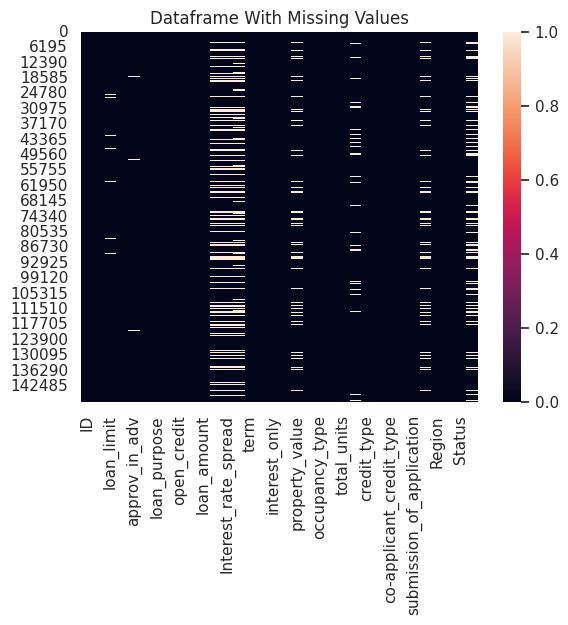

In [176]:
sns.heatmap(ds.isnull())
plt.title('Dataframe With Missing Values')
plt.savefig('missing_values.png')
plt.show()

In [ ]:
(ds.isnull().sum() / ds.shape[0]) * 100

In [ ]:
ds.drop(['ID', 'year'], axis=1, inplace=True)

In [ ]:
cat_features = []
num_features = []

In [ ]:
for cols in list(ds.columns):
    if ds[cols].dtype == 'object':
        cat_features.append(cols)
    else:
        num_features.append(cols)

In [181]:
print(f"Numerical Features: {num_features}")
print(f"Categorical Features: {cat_features}")

Numerical Features: ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'Status', 'dtir1']
Categorical Features: ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type']


In [182]:
most_null_cols = ds.loc[ds['Upfront_charges'].isna(), ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'Status', 'loan_amount']]
most_nonnull_cols = ds.loc[~ds['Upfront_charges'].isna(), ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'Status', 'loan_amount']]

In [183]:
most_null_cols['Status'].value_counts()

Status
1    36486
0     3156
Name: count, dtype: int64

In [184]:
most_nonnull_cols['Status'].value_counts()

Status
0    108875
1       153
Name: count, dtype: int64

### Handling Missing Values in Defaulted Loans

#### Problem

- All defaulted loans are missing values in the following columns: `'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges'`.
- These columns represent crucial information about the financial cost of the loan.

#### Solution

To handle these missing values and avoid data leakage, we can use the KNNImputer to impute the missing values based on the values of neighboring observations.

Here’s how you can do it:

1. **Identify Missing Columns**: `['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges']`
2. **Use KNNImputer**: Impute missing values using the K-Nearest Neighbors approach.


### Key Points:

- **Avoid Data Leakage**: Using KNNImputer helps in avoiding data leakage by imputing values based on similar observations without introducing information from the target variable.
- **Improved Model Performance**: Proper handling of missing values ensures that the model can be trained effectively without bias or missing data issues.

By implementing this approach, you ensure that the missing values in crucial financial cost columns are filled in a way that maintains the integrity of the dataset and supports accurate model training.

In [185]:
for cols in cat_features:
    mode = ds[cols].mode()[0]
    ds[cols] = ds[cols].fillna(mode)

### Categorical Null Values

- Input the mode for categorical null columns

In [186]:
imp_mean = KNNImputer(n_neighbors=3)

In [187]:
ds[num_features] = imp_mean.fit_transform(ds[num_features])

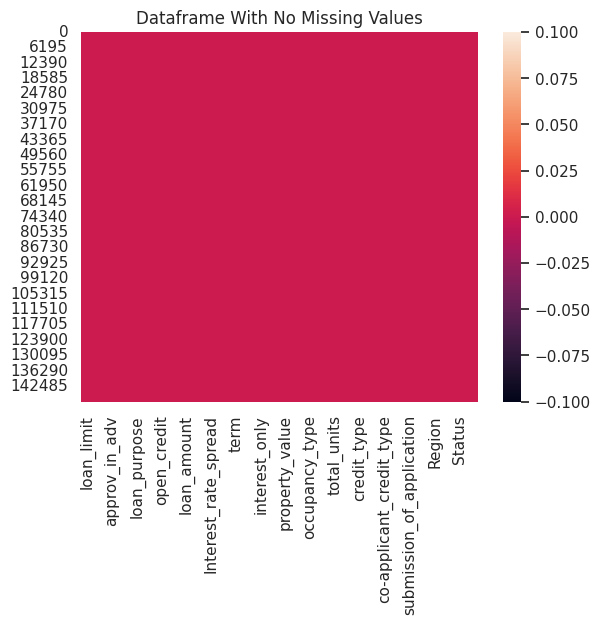

In [188]:
sns.heatmap(ds.isnull())
plt.title('Dataframe With No Missing Values')
plt.savefig('no_missing_values.png')
plt.show()

In [189]:
ds.isnull().sum()

loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
property_value               0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
income                       0
credit_type                  0
Credit_Score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
LTV                          0
Region                       0
Security_Type                0
Status                       0
dtir1                        0
dtype: i

In [190]:
ds['term'].isnull().sum()

0

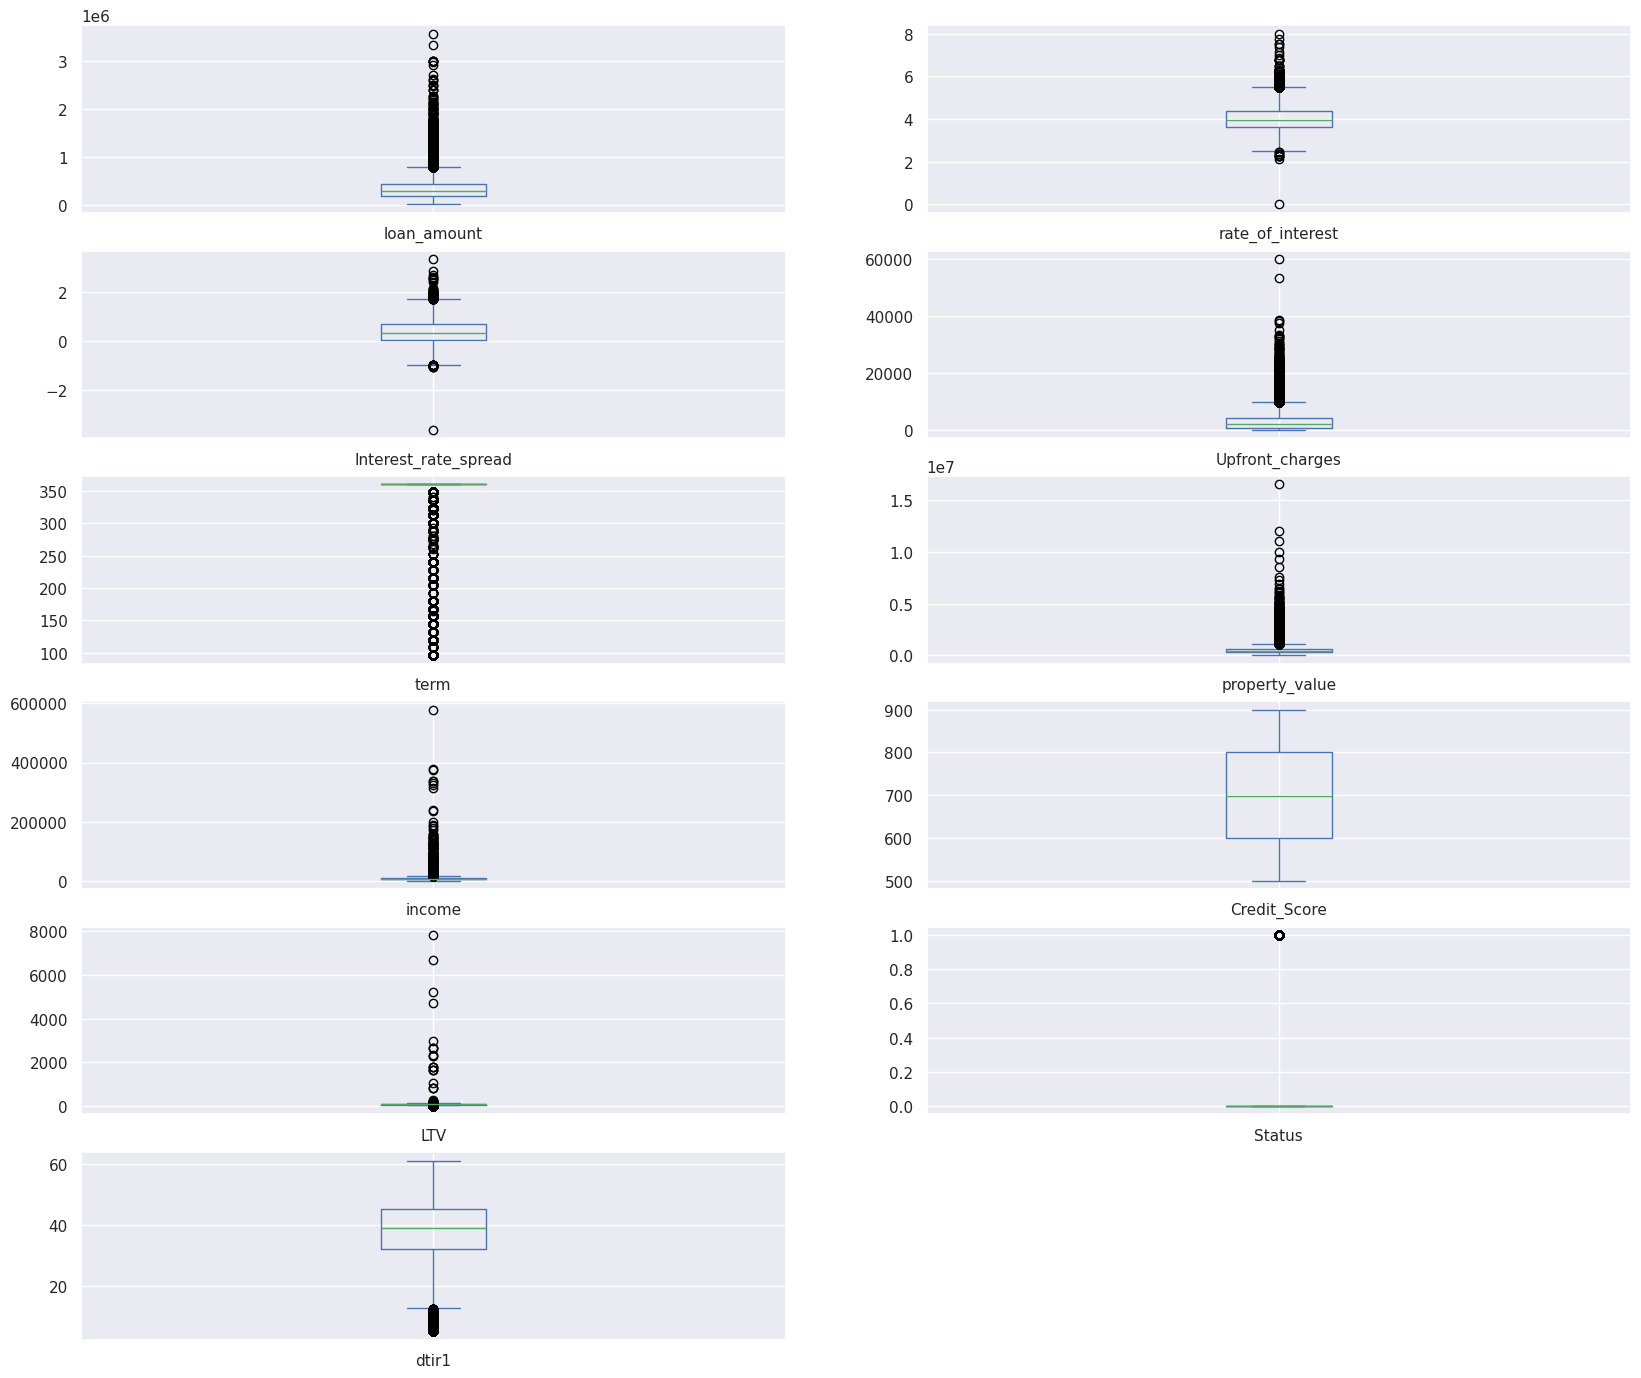

In [191]:
ds[num_features].plot(kind="box", subplots=True, layout=(7,2), figsize=(20,20))
plt.title('Numeric Features With Outliers')
plt.savefig('outlier_values.png')
plt.show()

In [192]:
def remove_outliers(col, ds):
    '''
    Remove outliers from a column, using the inter-quartile range
    - calculate the upper limit and lower limit based on the IQR
    - filter out observations that fall out of range (< lower_limit or > upper_limit)
    '''
    if col == 'Status':
        return ds
   
    q1 = ds[col].quantile(0.25)
    q3 = ds[col].quantile(0.75)
    
    iqr = q3 - q1
    
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    
    return ds.drop(ds[(ds[col] < lower_limit) | (ds[col] > upper_limit)].index)

In [193]:
for feat in num_features:
    ds = remove_outliers(feat, ds)

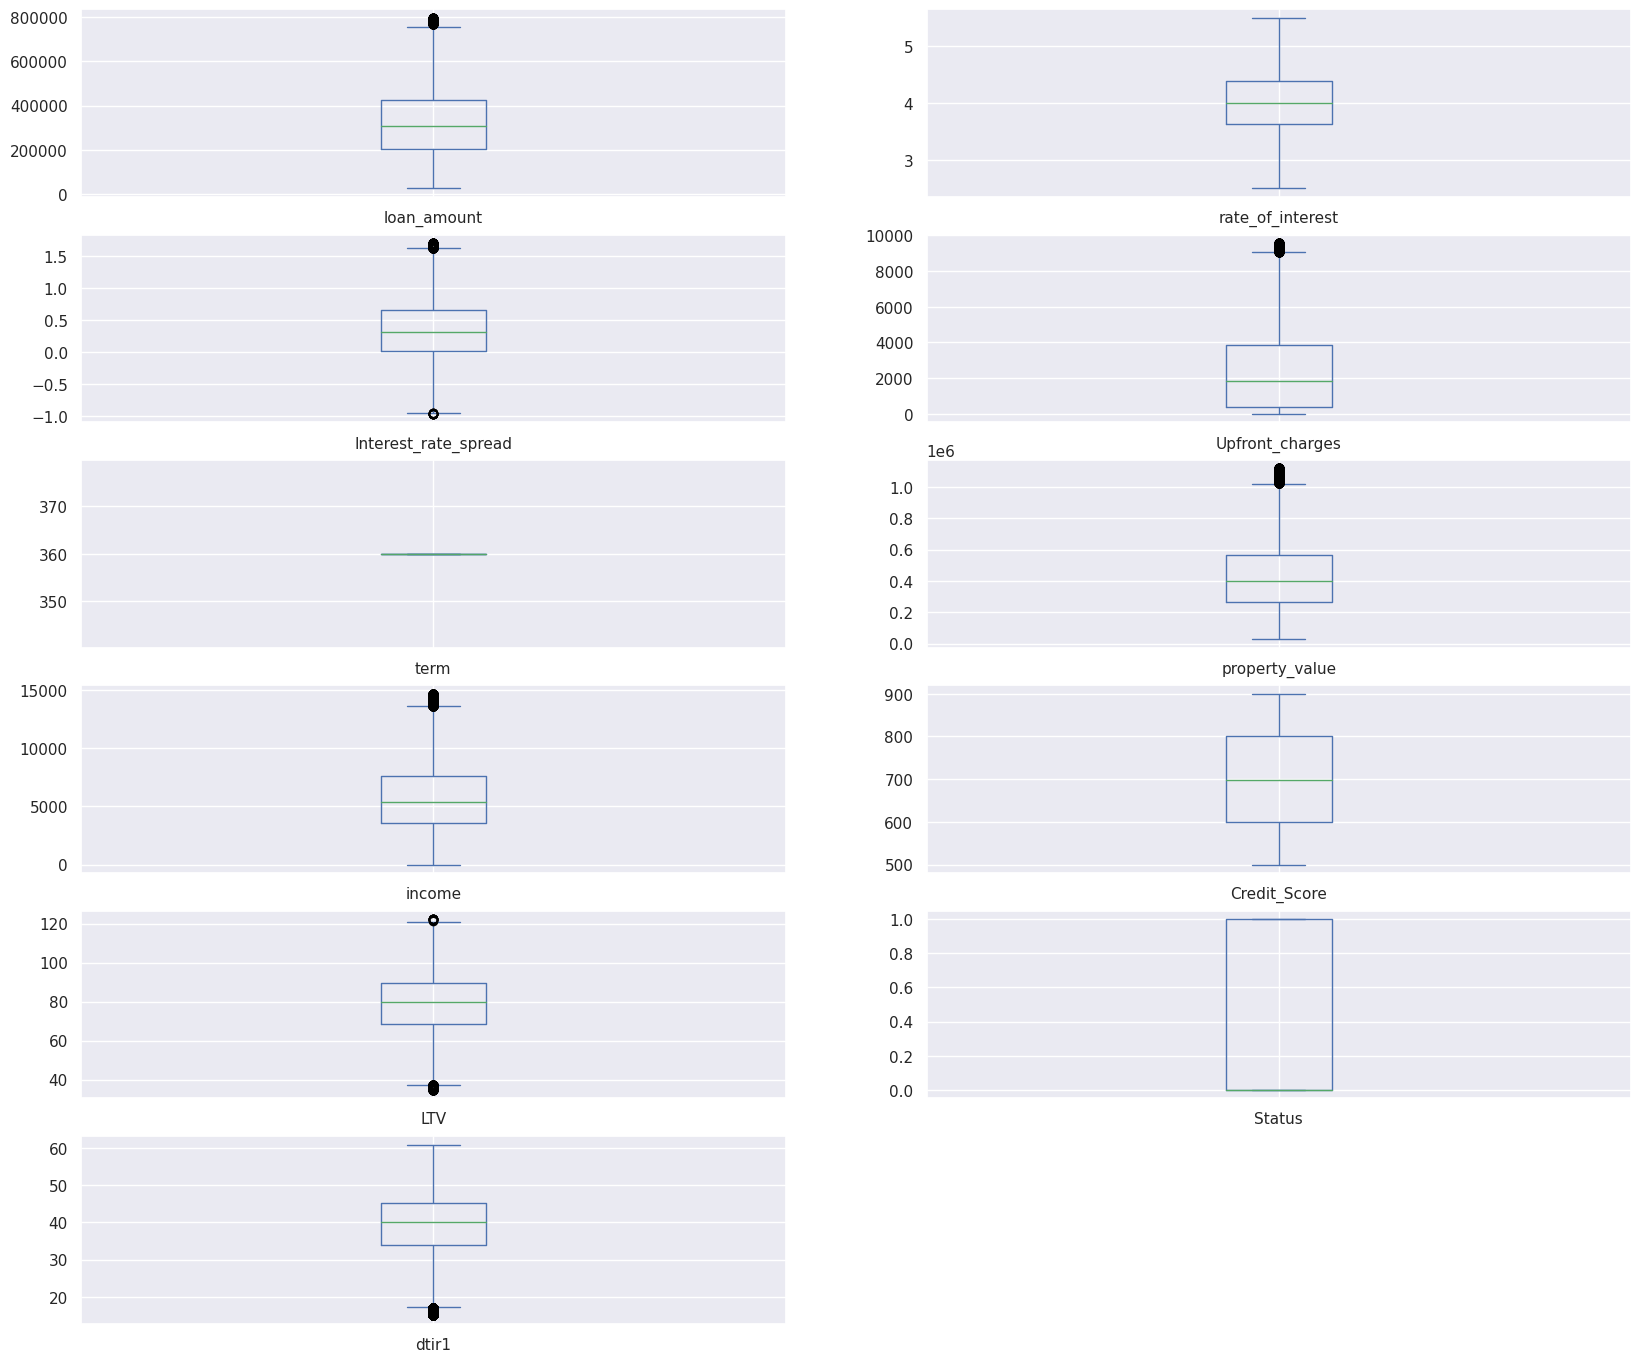

In [194]:
ds[num_features].plot(kind='box', subplots=True, layout=(7,2), figsize=(20,20))
plt.title('Numeric Features With No Outliers')
plt.savefig('no_outlier_values.png')
plt.show()

In [195]:
ds.columns

Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'loan_amount', 'rate_of_interest', 'Interest_rate_spread',
       'Upfront_charges', 'term', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'property_value', 'construction_type',
       'occupancy_type', 'Secured_by', 'total_units', 'income', 'credit_type',
       'Credit_Score', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'LTV', 'Region', 'Security_Type', 'Status',
       'dtir1'],
      dtype='object')

In [196]:
cleaned = ds.copy()

In [197]:
for col in cat_features:
    if cleaned[col].dtype == 'object':
        cleaned.loc[:,f"{col}_code"] = cleaned[col].astype('category').cat.codes
        cleaned = cleaned.drop(col, axis=1)

In [198]:
X = cleaned.drop('Status', axis=1).values
y = cleaned['Status'].values

In [199]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [200]:
rfc = RandomForestClassifier(random_state=11)

In [201]:
rfc.fit(X_scaled, y)

RandomForestClassifier(random_state=11)

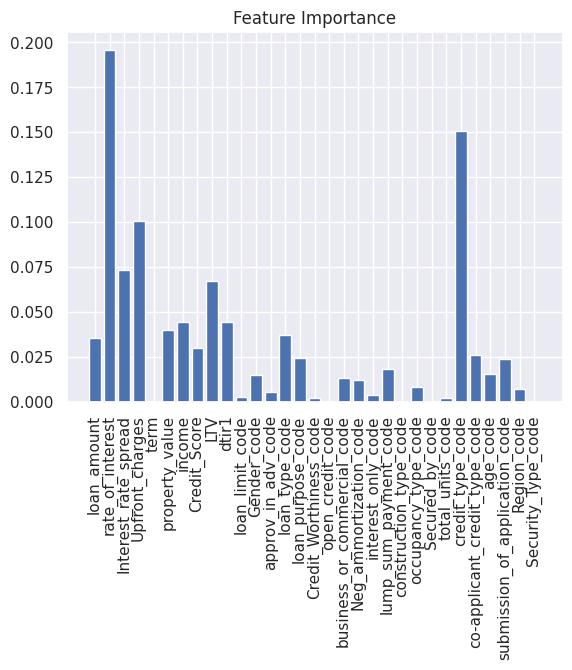

In [202]:
plt.bar(cleaned.drop('Status', axis=1).columns, rfc.feature_importances_)
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.savefig('feature_importance.png')
plt.show()

In [203]:
pd.DataFrame({
    'Feature': cleaned.drop('Status', axis=1).columns, 
    'Importance': rfc.feature_importances_
}).sort_values('Importance', ascending=False)

sorted_importance = pd.DataFrame({
    'Feature': cleaned.drop('Status', axis=1).columns, 
    'Importance': rfc.feature_importances_
}).sort_values('Importance', ascending=False)

### Most Important Features

According to the inferencial Model
- Rate of Interest is the most important feature when categorizing defaulters and non-defaulters
- Term is the least importance, with an importance value of 0
- Credit type, Upfront charges, Interest Rate Spread, and LTV round up the top 5 most important features.

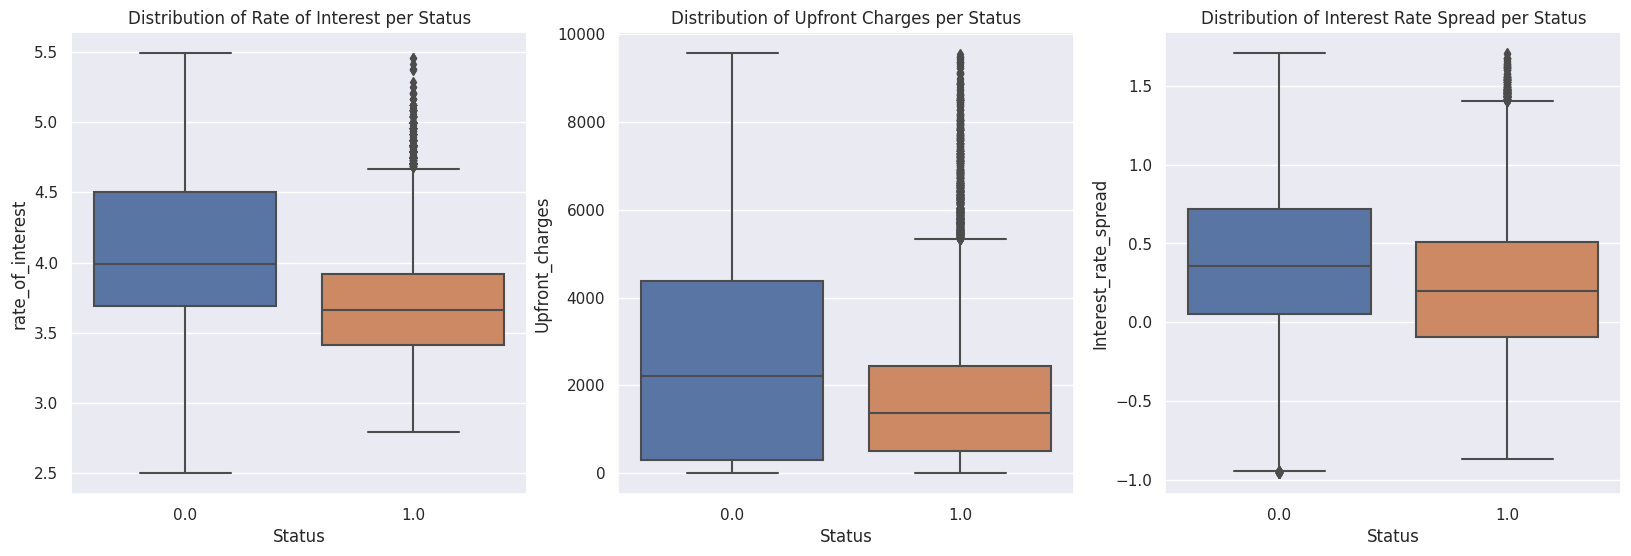

In [210]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 6))

sns.boxplot(data=ds, x='Status', y='rate_of_interest', ax=ax1)
ax1.set_title('Distribution of Rate of Interest per Status')

sns.boxplot(data=ds, x='Status', y='Upfront_charges', ax=ax2)
ax2.set_title('Distribution of Upfront Charges per Status')

sns.boxplot(data=ds, x='Status', y='Interest_rate_spread', ax=ax3)
ax3.set_title('Distribution of Interest Rate Spread per Status')

plt.savefig('key_features.png')
plt.show()

### Analysis of Key Features for Defaulted Loans

#### Findings

Based on the analysis, the following features are lower on average for defaulted loans compared to non-defaulted loans:

1. **Upfront Charges**
2. **Interest Rate Spread**
3. **Rate of Interest**

#### Interpretation

1. **Upfront Charges**:
   - **Lower on Average**: Defaulted loans have lower upfront charges on average.
   - **Implication**: Lower upfront charges may indicate less initial financial commitment from the borrower, potentially leading to a higher risk of default.

2. **Interest Rate Spread**:
   - **Lower on Average**: Defaulted loans have a lower interest rate spread on average.
   - **Implication**: A lower spread might reflect less risk-based pricing, suggesting that these loans may not have adequately accounted for borrower risk.

3. **Rate of Interest**:
   - **Lower on Average**: Defaulted loans have a lower rate of interest on average.
   - **Implication**: Lower interest rates might attract higher-risk borrowers, or these loans might have been offered during periods of economic downturn with overall lower rates.

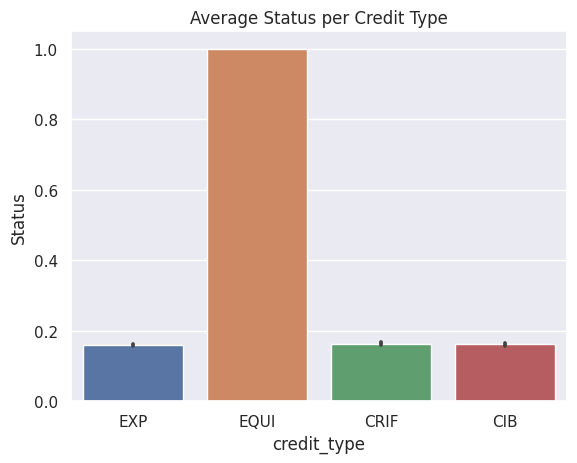

In [204]:
sns.barplot(data=ds, y='Status', x='credit_type')
plt.title('Average Status per Credit Type')
plt.savefig('average_status_per_credit_type.png')
plt.show()

### Analysis of Credit Type `EQUI`

#### Insight

- **Credit Type (`EQUI`)**: Loans with the 'EQUI' credit type have an average default status of 1.

#### Implication

- **High Default Risk**: Borrowers with the 'EQUI' credit type are at a high risk of defaulting.
- **Actionable Measures**:
  - **Careful Evaluation**: Loans to borrowers with 'EQUI' credit type should be carefully evaluated with additional scrutiny.
  - **Preferred Alternatives**: Consider preferring alternative credit types that show lower default rates.
  - **Risk Mitigation**: Implement additional risk mitigation strategies for loans with the 'EQUI' credit type, such as requiring higher collateral or offering financial counseling.

By focusing on these measures, the bank can better manage and mitigate the risk associated with loans under the 'EQUI' credit type.

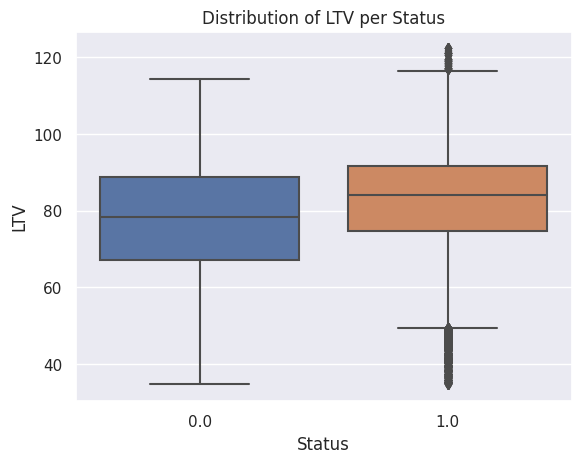

In [207]:
sns.boxplot(data=ds, x='Status', y='LTV')
plt.title('Distribution of LTV per Status')
plt.savefig('dist_of_LTV.png')
plt.show()

### Analysis of Loan-to-Value (LTV) Ratio in Defaulted Loans

Based on the boxplot analysis comparing defaulted and non-defaulted loans:

- **Observation**: The average Loan-to-Value (LTV) ratio is higher for defaulted loans than for non-defaulted loans.
  
- **Implication**: A higher LTV ratio signifies that borrowers have borrowed a larger percentage of the property's value. This suggests greater financial leverage and potentially higher risk for lenders, as borrowers may struggle to repay the loan if property values decline or financial circumstances change adversely.

Understanding this relationship is critical for lenders:

- **Risk Assessment**: Higher LTV ratios are associated with increased risk of default, influencing loan approval and terms.
  
- **Risk Management**: Lenders may implement stricter lending criteria or require additional guarantees for loans with higher LTV ratios to mitigate potential losses from defaults.

By acknowledging the impact of LTV ratios on loan defaults, lenders can enhance risk management strategies and make informed decisions that promote financial stability and borrower satisfaction.

In [206]:
ds.head()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500.0,3.583333,...,EXP,758.0,CIB,25-34,to_inst,98.728814,south,direct,1.0,45.000000
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500.0,3.708333,...,EQUI,552.0,EXP,55-64,to_inst,84.795549,North,direct,1.0,34.666667
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500.0,4.560000,...,EXP,834.0,CIB,35-44,to_inst,80.019685,south,direct,0.0,46.000000
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500.0,4.250000,...,EXP,587.0,CIB,45-54,not_inst,69.376900,North,direct,0.0,42.000000
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500.0,4.000000,...,CRIF,602.0,EXP,25-34,not_inst,91.886544,North,direct,0.0,39.000000


In [88]:
cleaned = ds.copy()

In [89]:
cleaned.head()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500.0,3.583333,...,EXP,758.0,CIB,25-34,to_inst,98.728814,south,direct,1.0,45.000000
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500.0,3.708333,...,EQUI,552.0,EXP,55-64,to_inst,84.795549,North,direct,1.0,34.666667
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500.0,4.560000,...,EXP,834.0,CIB,35-44,to_inst,80.019685,south,direct,0.0,46.000000
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500.0,4.250000,...,EXP,587.0,CIB,45-54,not_inst,69.376900,North,direct,0.0,42.000000
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500.0,4.000000,...,CRIF,602.0,EXP,25-34,not_inst,91.886544,North,direct,0.0,39.000000


In [90]:
for col in list(cleaned.columns):
    if cleaned[col].dtype == 'object':
        cleaned.loc[:,f"{col}_code"] = cleaned[col].astype('category').cat.codes
        cleaned = cleaned.drop(col, axis=1)

In [91]:
cleaned_filtered = cleaned.copy()

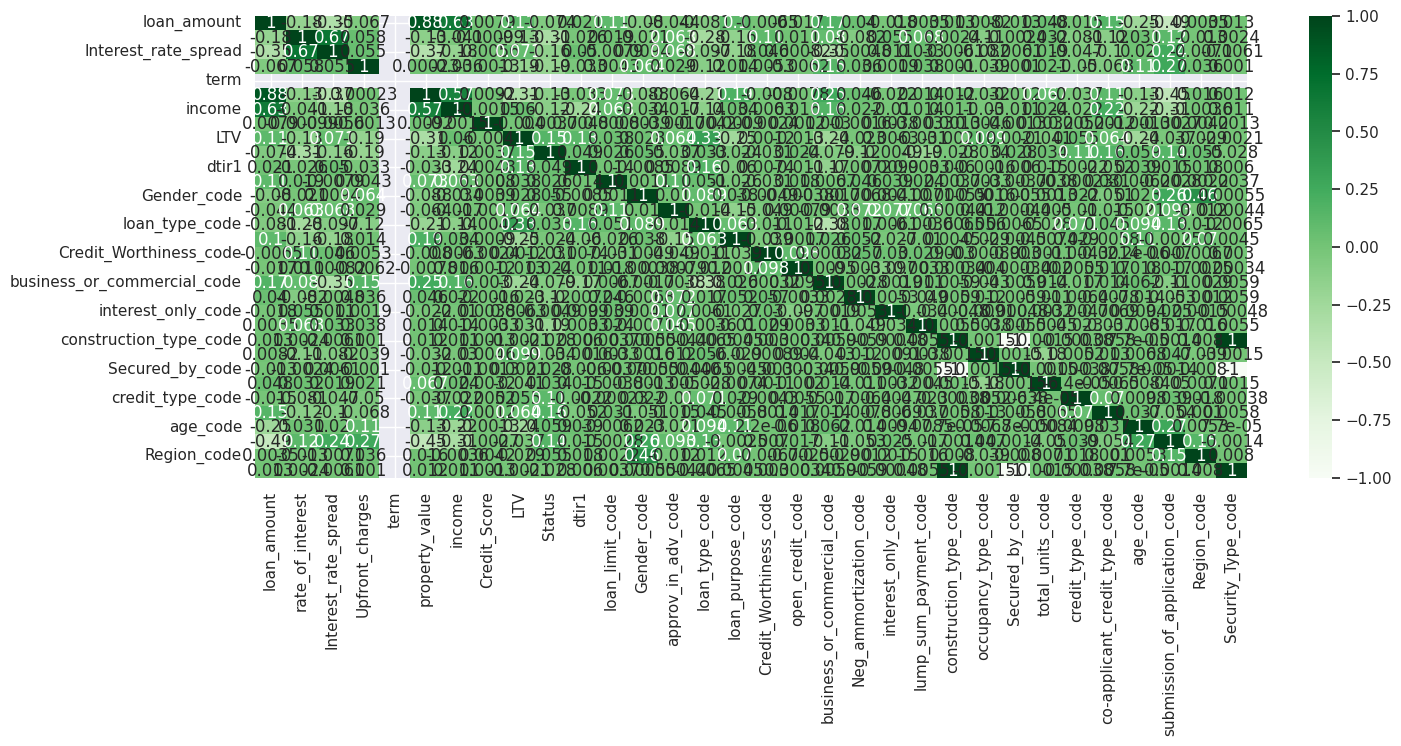

In [92]:
plt.figure(figsize=(16, 6))
sns.heatmap(cleaned[list(cleaned.select_dtypes(include='number').columns)].corr(), cmap='Greens', vmin=-1, vmax=1, annot=True)
plt.title('Correlation Map')
plt.savefig('correlation_map.png')
plt.show()

In [93]:
high_importance_cols = ['Status']

for index, row in sorted_importance.iterrows():
    if row['Importance'] >= 0.02:
        print(f"{row['Feature']}: {row['Importance']}")
        high_importance_cols.append(row['Feature'])

rate_of_interest: 0.19591384600890127
credit_type_code: 0.1509966799951491
Upfront_charges: 0.10070505689343054
Interest_rate_spread: 0.07311103753736385
LTV: 0.0674555060563923
dtir1: 0.04458505681276994
income: 0.044560679410883826
property_value: 0.040218114732153726
loan_type_code: 0.03709842793167108
loan_amount: 0.03561604739278958
Credit_Score: 0.02970966220989695
co-applicant_credit_type_code: 0.02621255401920775
loan_purpose_code: 0.02464671136329215
submission_of_application_code: 0.023679106160445395


In [94]:
len(high_importance_cols)

15

In [95]:
high_importance_cols

['Status',
 'rate_of_interest',
 'credit_type_code',
 'Upfront_charges',
 'Interest_rate_spread',
 'LTV',
 'dtir1',
 'income',
 'property_value',
 'loan_type_code',
 'loan_amount',
 'Credit_Score',
 'co-applicant_credit_type_code',
 'loan_purpose_code',
 'submission_of_application_code']

In [96]:
cleaned_filtered = cleaned_filtered[high_importance_cols]

In [97]:
cleaned.drop(['property_value', 'Interest_rate_spread', 'income'], axis=1, inplace=True)
cleaned_filtered.drop(['property_value', 'Interest_rate_spread', 'income'], axis=1, inplace=True)

In [109]:
X = cleaned.drop('Status', axis=1)
y = cleaned['Status']

In [110]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [145]:
xgb = XGBClassifier(random_state=11, n_estimators=500)

In [146]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [148]:
scores_f1_cleaned = cross_val_score(xgb, X_scaled, y, cv=cv, scoring='f1', n_jobs=4)
scores_roc_cleaned = cross_val_score(xgb, X_scaled, y, cv=cv, scoring='roc_auc', n_jobs=4)

In [149]:
print(f"f1 scores: {scores_f1_cleaned}, mean: {np.mean(scores_f1_cleaned)}")
print(f"roc_auc scores: {scores_roc_cleaned}, mean: {np.mean(scores_roc_cleaned)}")

f1 scores: [0.94612829 0.94561509 0.94549455 0.93861867 0.93344107], mean: 0.9418595319395955
roc_auc scores: [0.99112291 0.99009413 0.98972896 0.98925207 0.98762485], mean: 0.9895645838375303


With Params
- f1 scores: [0.94099695 0.94220063 0.94105732 0.93833452 0.93043746], mean: 0.9386053751251839
- roc_auc scores: [0.99134691 0.99036442 0.99007917 0.98994803 0.98839592], mean: 0.9900268917055003
- f1 scores: [0.94038684 0.94026415 0.93660031], mean: 0.9390837658282267
- roc_auc scores: [0.99123062 0.98980608 0.98901779], mean: 0.9900181631453391

Without Params
- f1 scores: [0.94516813 0.94546921 0.94526464 0.93817368 0.93097129], mean: 0.9410093895258193
- roc_auc scores: [0.99173367 0.99054521 0.99033164 0.98994303 0.98867901], mean: 0.990246511111587
- f1 scores: [0.94223301 0.94099173 0.93738557], mean: 0.9402034361043495
- roc_auc scores: [0.99134716 0.98951055 0.98890094], mean: 0.9899195498860944

In [104]:
X = cleaned_filtered.drop('Status', axis=1)
y = cleaned_filtered['Status']

In [105]:
X_scaled = scaler.fit_transform(X)

In [106]:
scores_f1_filtered = cross_val_score(xgb, X_scaled, y, cv=cv, scoring='f1', n_jobs=4)
scores_roc_filtered = cross_val_score(xgb, X_scaled, y, cv=cv, scoring='roc_auc', n_jobs=4)

In [107]:
print(f"f1 scores: {scores_f1_filtered}")
print(f"roc_auc scores: {scores_roc_filtered}")

f1 scores: [0.94167765 0.9431979  0.94232511 0.93702873 0.92750967]
roc_auc scores: [0.99054444 0.98921032 0.9889518  0.9891335  0.9865892 ]


In [211]:
knn = KNeighborsClassifier(n_neighbors=10)

In [111]:
scores_f1_cleaned = cross_val_score(knn, X_scaled, y, cv=cv, scoring='f1', n_jobs=4)
scores_roc_cleaned = cross_val_score(knn, X_scaled, y, cv=cv, scoring='roc_auc', n_jobs=4)

In [112]:
print(f"f1 scores: {scores_f1_cleaned}")
print(f"roc_auc scores: {scores_roc_cleaned}")

f1 scores: [0.70613108 0.70090846 0.6959972  0.69995323 0.69443793]
roc_auc scores: [0.90149281 0.897131   0.895034   0.89561167 0.8947317 ]


In [154]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=11, verbose=-1, n_jobs=-1, n_estimators=500)

scores_f1_cleaned = cross_val_score(lgbm, X_scaled, y, cv=cv, scoring='f1', n_jobs=4)
scores_roc_cleaned = cross_val_score(lgbm, X_scaled, y, cv=cv, scoring='roc_auc', n_jobs=4)

print(f"f1 scores: {scores_f1_cleaned}, mean: {np.mean(scores_f1_cleaned)}")
print(f"roc_auc scores: {scores_roc_cleaned}, mean: {np.mean(scores_roc_cleaned)}")

f1 scores: [0.96371814 0.96483516 0.96555157 0.96618454 0.96450355], mean: 0.9649585934283115
roc_auc scores: [0.99542842 0.99476553 0.99395055 0.99607327 0.99517776], mean: 0.9950791059575049


Without Params
- f1 scores: [0.95575935 0.95806581 0.95903035 0.95905844 0.95857631], mean: 0.9580980532146046
- roc_auc scores: [0.99390785 0.99338962 0.99301944 0.99488767 0.99391506], mean: 0.9938239283528179

With Params
- f1 scores: [0.96371814 0.96483516 0.96555157 0.96618454 0.96450355], mean: 0.9649585934283115
- roc_auc scores: [0.99542842 0.99476553 0.99395055 0.99607327 0.99517776], mean: 0.9950791059575049

In [157]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(random_state=11, verbose=0)

scores_f1_cleaned = cross_val_score(cat, X_scaled, y, cv=cv, scoring='f1', n_jobs=4)
scores_roc_cleaned = cross_val_score(cat, X_scaled, y, cv=cv, scoring='roc_auc', n_jobs=4)

print(f"f1 scores: {scores_f1_cleaned}, mean: {np.mean(scores_f1_cleaned)}")
print(f"roc_auc scores: {scores_roc_cleaned}, mean: {np.mean(scores_roc_cleaned)}")

f1 scores: [0.96174315 0.96363636 0.96569605 0.96468941 0.96239248], mean: 0.9636314893826899
roc_auc scores: [0.99533061 0.99499803 0.99431227 0.99598086 0.99549346], mean: 0.9952230481218807


Without Params
- f1 scores: [0.96174315 0.96363636 0.96569605 0.96468941 0.96239248], mean: 0.9636314893826899
- roc_auc scores: [0.99533061 0.99499803 0.99431227 0.99598086 0.99549346], mean: 0.9952230481218807

With Params
- f1 scores: [0.9618933  0.96313318 0.96467771 0.96548965 0.96281447], mean: 0.9636016621208203
- roc_auc scores: [0.99513173 0.99470967 0.99431456 0.99589796 0.99536717], mean: 0.9950842182396699

In [158]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('cat', cat),
    ('xgb', xgb)
]

final_estimator = lgbm

stack = StackingClassifier(estimators=estimators, final_estimator=final_estimator, n_jobs=-1)

scores_f1_cleaned = cross_val_score(stack, X_scaled, y, cv=cv, scoring='f1', n_jobs=-1)
scores_roc_cleaned = cross_val_score(stack, X_scaled, y, cv=cv, scoring='roc_auc', n_jobs=-1)

print(f"f1 scores: {scores_f1_cleaned}, mean: {np.mean(scores_f1_cleaned)}")
print(f"roc_auc scores: {scores_roc_cleaned}, mean: {np.mean(scores_roc_cleaned)}")

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


f1 scores: [0.96312494 0.9645755  0.96495904 0.96483909 0.96313959], mean: 0.9641276322019726
roc_auc scores: [0.99454887 0.99363662 0.99347152 0.99530544 0.99464042], mean: 0.9943205732631176


In [159]:
averages = {
    "Model": ["XGB", "KNN", "LGBM", "CAT", "STACK"],
    "Avg_F1_score": [0.9410093895258193, 0.69928518, 0.9649585934283115, 0.9636314893826899, 0.9641276322019726],
    "Avg_Roc_auc": [0.990246511111587, 0.8966000359999999, 0.9950791059575049, 0.9952230481218807, 0.9943205732631176],
    "Note": [
        "Best average cross val score achieved without setting any parameters",
        "Without params. Baseline score to low to pursue",
        "Best average cross val score achieved with 500 estimators",
        "Best average cross val score achieved without setting any parameters",
        "With XGB, CAT and LGBM as the final model"
    ]
}

In [161]:
results = pd.DataFrame(averages)

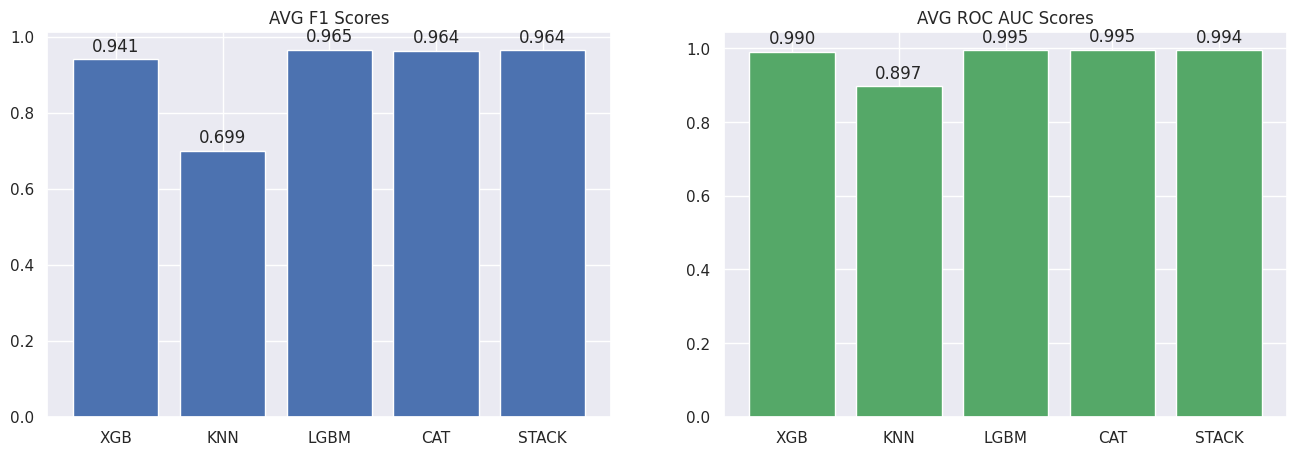

In [166]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

bars1 = ax1.bar(results['Model'], results['Avg_F1_score'], color='b')
ax1.set_title('AVG F1 Scores')
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords='offset points', ha='center', va='bottom')

bars2 = ax2.bar(results['Model'], results['Avg_Roc_auc'], color='g')
ax2.set_title('AVG ROC AUC Scores')
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords='offset points', ha='center', va='bottom')


plt.savefig('Average Scores')
plt.show()

I am selecting the LGBM (LightGBM) model primarily because it achieved the highest average F1 score of 0.965 and a strong ROC AUC score of 0.995. These scores indicate robust performance across key metrics, demonstrating its effectiveness in classification tasks. Additionally, the model has been optimized with 500 estimators, further enhancing its predictive capabilities. LGBM's efficiency in training and prediction, along with its scalability for large datasets, makes it a suitable and practical choice for real-world applications where performance and speed are crucial.